In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import plot_utils
from matplotlib.backends.backend_pdf import PdfPages
from tqdm.notebook import tqdm

# Join results from multiple classifiers

In [3]:
seed = 0
data_dir = '../probing'
output_dir = '../probing/predictions'
num_labels = 10

In [4]:
bin_edges = np.linspace(0, 512, num_labels + 1)[1:]

In [28]:
with open(os.path.join(data_dir, 'split', f'seed{seed}.json'), 'r') as fin:
    split = json.load(fin)
test_ids = set(split['test'])

with open(os.path.join(data_dir, 'llama3-10-15-5k.json'), 'r') as fin:
    records = json.load(fin)['records'][1:]

test_records = [x for x in records if x['record_id'] in test_ids]

In [12]:
def convert_logit_to_pred(logits, bin_edges):
    exp_x = np.exp(logits - np.amax(logits))
    proba = exp_x / np.sum(exp_x)
    return np.sum([p * b for p, b in zip(proba, bin_edges)])

def convert_logit_to_proba(logits):
    exp_x = np.exp(logits - np.amax(logits))
    return (exp_x / np.sum(exp_x)).tolist()

In [56]:
with open(os.path.join(output_dir, f'bert_pred_seed{seed}.json'), 'r') as fin:
    bert_pred_raw = json.load(fin)

bert_pred = dict()

for brec in tqdm(bert_pred_raw):
    bert_pred[brec['id']] = convert_logit_to_proba(brec['logits'])

  0%|          | 0/1477 [00:00<?, ?it/s]

In [58]:
# This cell is to export probabilities
# This cell is to export raw predictions

output = list()
id2gt = dict()

for r in test_records:
    raw_prompt = r['output']
    pstart = raw_prompt.index('Below is an instruction')
    pend = raw_prompt.index('### Response:')
    prompt = raw_prompt[pstart:pend] + '### Response:'
    output.append({
        "id": r['record_id'],
        "prompt": prompt,
        "groundtruth": r['iteration_count'],
        'pred_by_bert': bert_pred.get(r['record_id'], None)
    })
    id2gt[r['record_id']] = r['iteration_count']

ids = [x['id'] for x in output]
sorted_idx = np.argsort(ids)
output = [output[i] for i in sorted_idx]

missing_layers = list()
for layer_idx in tqdm(range(10, 16)):

    pred_by_id = dict()

    cached_pred_path = os.path.join(output_dir, f'L{layer_idx}_class{num_labels}_seed{seed}.pkl')
    cached_prompt_pred_path = os.path.join(output_dir, f'L{layer_idx}_class{num_labels}_prompt_seed{seed}.pkl')
    if os.path.isfile(cached_pred_path):
        with open(cached_pred_path, 'rb') as fout:
            pred_raw = pkl.load(fout)
        
        with open(cached_prompt_pred_path, 'rb') as fout:
            prompt_pred_raw = pkl.load(fout)
        
        prompt_df = pd.DataFrame(prompt_pred_raw)
        assert(prompt_df.shape[0] == prompt_df.groupby(by='id').ngroups)

        prompt_pred_dict = dict()
        for _, row in prompt_df.iterrows():
            prompt_pred_dict[row['id']] = convert_logit_to_proba(row['pred'])
        
        pred = list()
        for raw in pred_raw:
            pred.append({
                'id': raw['id'],
                'remaining_steps': raw['remaining_steps'],
                'pred': convert_logit_to_proba(raw['pred'])
            })
        
        pred = pd.DataFrame(pred)
        grb_id = pred.groupby(by='id')
        
        for id, sub_df in grb_id:
            rs, ps = sub_df.remaining_steps.values, sub_df.pred.values
            gt = id2gt[id]
            # sorted_idx = np.argsort(rs)[::-1]
            # rs = rs[sorted_idx]
            # ps = [ps[i] for i in sorted_idx]

            r2p = dict()
            for r, p in zip(rs, ps):
                r2p[r] = p

            ordered_p = list()
            for remaining_step in range(gt - 2, -1, -1):
                ordered_p.append(r2p.get(remaining_step, None))
            
            pred_by_id[id] = ordered_p
        
        for rec in output:
            prompt_pred_vec = prompt_pred_dict.get(rec['id'], None)
            rec[f'pred_by_prompt_embedding_L{layer_idx}'] = prompt_pred_vec
            pred_vec = pred_by_id.get(rec['id'], None)
            if pred_vec is not None:
                rec[f'pred_refined_L{layer_idx}'] = pred_vec
    else:
        missing_layers.append(layer_idx)

  0%|          | 0/6 [00:00<?, ?it/s]

In [59]:
output[0]

{'id': 1,
 'prompt': 'Below is an instruction that describes a task. Write a response that appropriately completes the request. ### Instruction: What are the three primary colors? ### Response:',
 'groundtruth': 18,
 'pred_by_bert': [0.4881193255711182,
  0.22819618838111752,
  0.07058635985924122,
  0.04944478750372689,
  0.04757584660210211,
  0.03362739342785896,
  0.023772771399842563,
  0.018949007798492176,
  0.02066821655987247,
  0.019060102896627993],
 'pred_by_prompt_embedding_L10': [0.8878200650215149,
  0.09170567989349365,
  0.016497189179062843,
  0.003504479769617319,
  0.00039158647996373475,
  8.000997331691906e-05,
  8.482186331093544e-07,
  1.0826695273635778e-07,
  3.5548117782724376e-09,
  2.991405040342343e-11],
 'pred_refined_L10': [[0.7332195043563843,
   0.23669366538524628,
   0.028830209746956825,
   0.0011596387485042214,
   8.31316428957507e-05,
   1.2712313946394715e-05,
   1.0795401976793073e-06,
   8.530761874681048e-08,
   5.276699965861553e-09,
   1.04

In [39]:
for rec in output:
    gt = rec['groundtruth']
    for lid in range(10, 16):
        if f'pred_refined_L{lid}' in rec.keys():
            assert(len(rec[f'pred_refined_L{lid}']) == gt - 1)
        else:
            print(rec['id'], f"missing prediction from layer {lid}")

867 missing prediction from layer 10
867 missing prediction from layer 11
867 missing prediction from layer 12
2464 missing prediction from layer 11
2464 missing prediction from layer 14
2464 missing prediction from layer 15
2657 missing prediction from layer 13


In [60]:
with open(f'eval/alpaca6k-by-layer-10-15-seed{seed}-class{num_labels}.json', 'w') as fout:
    json.dump(output, fout, indent=2)

## Compare per-layer prediction accuracies

This uses Alpaca1K instead of Aplaca6k

In [18]:
seed = 0
data_dir = '../chunwei-data'
output_dir = '../chunwei-data/predictions'
num_labels = 10

In [19]:
bin_edges = np.linspace(0, 512, num_labels + 1)[1:]

In [20]:
with open(os.path.join(data_dir, 'split', f'seed{seed}.json'), 'r') as fin:
    split = json.load(fin)
test_ids = set(split['test'])

with open(os.path.join(data_dir, 'all_layers_1k.json'), 'r') as fin:
    records = json.load(fin)['records'][1:]

test_records = [x for x in records if x['record_id'] in test_ids]

In [21]:
def convert_logit_to_pred(logits, bin_edges):
    exp_x = np.exp(logits - np.amax(logits))
    proba = exp_x / np.sum(exp_x)
    return np.sum([p * b for p, b in zip(proba, bin_edges)])

In [29]:
output = list()
id2gt = dict()

for r in test_records:
    raw_prompt = r['output']
    pstart = raw_prompt.index('Below is an instruction')
    pend = raw_prompt.index('### Response:')
    prompt = raw_prompt[pstart:pend] + '### Response:'
    output.append({
        "id": r['record_id'],
        "prompt": prompt,
        "groundtruth": r['iteration_count'],
    })
    id2gt[r['record_id']] = r['iteration_count']

ids = [x['id'] for x in output]
sorted_idx = np.argsort(ids)
output = [output[i] for i in sorted_idx]

missing_layers = list()
error_by_layer_dict = dict()
for layer_idx in tqdm(range(32)):
    pred_by_id = dict()

    cached_pred_path = os.path.join(output_dir, f'L{layer_idx}_class{num_labels}_seed{seed}.pkl')
    if os.path.isfile(cached_pred_path):
        with open(cached_pred_path, 'rb') as fout:
            pred_raw = pkl.load(fout)

        pred = list()
        for raw in pred_raw:
            pred.append({
                'id': raw['id'],
                'remaining_steps': raw['remaining_steps'],
                'pred': convert_logit_to_pred(raw['pred'], bin_edges)
            })
        
        pred = pd.DataFrame(pred)
        grb_id = pred.groupby(by='id')
        
        error_layer = list()
        for id, sub_df in grb_id:
            if id in test_ids:
                rs, ps = sub_df.remaining_steps.values, sub_df.pred.values
                abs_err = np.abs(rs - ps).tolist()
                error_layer.extend(abs_err)
        
        error_by_layer_dict[layer_idx] = error_layer
    else:
        missing_layers.append(layer_idx)

  0%|          | 0/32 [00:00<?, ?it/s]

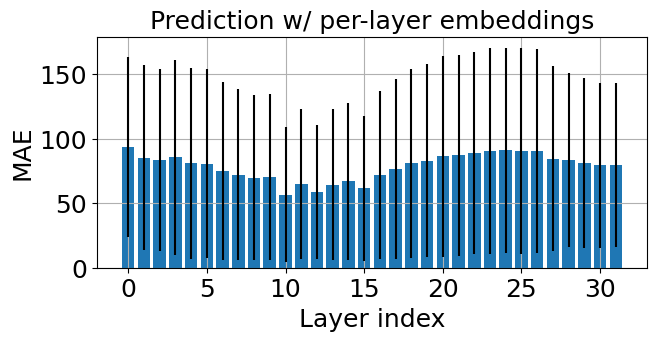

In [38]:
layer_list = list(range(32))
err_mean = [np.mean(error_by_layer_dict[i]) for i in layer_list]
err_std = [np.std(error_by_layer_dict[i]) for i in layer_list]

fig, ax = plt.subplots(figsize=(7.1, 3))
ax.bar(layer_list, err_mean, yerr=err_std)

plt.xlabel('Layer index', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.title('Prediction w/ per-layer embeddings', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
plt.grid()

pp = PdfPages(os.path.join('figs', 'per_layer_predictions.pdf'))
pp.savefig(bbox_inches='tight')
pp.close()

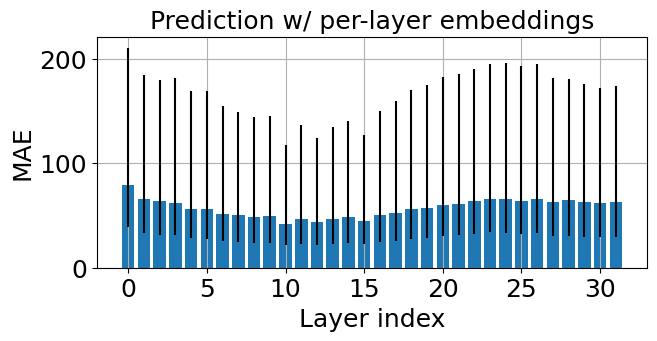

In [39]:
layer_list = list(range(32))
err_median = np.array([np.median(error_by_layer_dict[i]) for i in layer_list])
err_lo = np.array([np.percentile(error_by_layer_dict[i], q=25) for i in layer_list])
err_hi = np.array([np.percentile(error_by_layer_dict[i], q=75) for i in layer_list])

fig, ax = plt.subplots(figsize=(7.1, 3))
ax.bar(layer_list, err_median, yerr=[err_lo, err_hi])

plt.xlabel('Layer index', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.title('Prediction w/ per-layer embeddings', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
plt.grid()

pp = PdfPages(os.path.join('figs', 'per_layer_predictions.pdf'))
pp.savefig(bbox_inches='tight')
pp.close()

# Compare datasets

In [44]:
with open('eval/alpaca_chunwei_version_with_similarity.json', 'r') as fin:
    predictions = json.load(fin)

In [57]:
predictions[0].keys()

dict_keys(['id', 'prompt', 'groundtruth', 'pred_by_prompt', 'pred_by_prompt_embedding', 'pred_refined_with_smoothing', 'uae_average_5', 'uae_average_10', 'uae_average_20', 'uae_average_30', 'uae_average_40', 'uae_average_50', 'sfr_average_5', 'sfr_average_10', 'sfr_average_20', 'sfr_average_30', 'sfr_average_40', 'sfr_average_50'])

In [65]:
predictos = ['pred_by_prompt', 'pred_by_prompt_embedding', 'uae_average_5', 'uae_average_10', 'uae_average_20', 'uae_average_30', 'uae_average_40', 'uae_average_50', 'sfr_average_5', 'sfr_average_10', 'sfr_average_20', 'sfr_average_30', 'sfr_average_40', 'sfr_average_50']

In [63]:
keep_cols = ['id', 'groundtruth', ] + ['pred_by_prompt', 'pred_by_prompt_embedding', 'uae_average_5', 'uae_average_10', 'uae_average_20', 'uae_average_30', 'uae_average_40', 'uae_average_50', 'sfr_average_5', 'sfr_average_10', 'sfr_average_20', 'sfr_average_30', 'sfr_average_40', 'sfr_average_50']
pred_clean = list()

for record in predictions:
    nd = dict()
    for kc in keep_cols:
        nd[kc] = record.get(kc, np.nan)
    pred_clean.append(nd)

pred_df = pd.DataFrame(pred_clean)
pred_df = pred_df[pred_df.id < 1000]

In [67]:
errors = list()

for pn in predictors:
    errors.append(
        np.abs(pred_df.groundtruth.values - pred_df[pn].values)
    )

errors = np.array(errors)

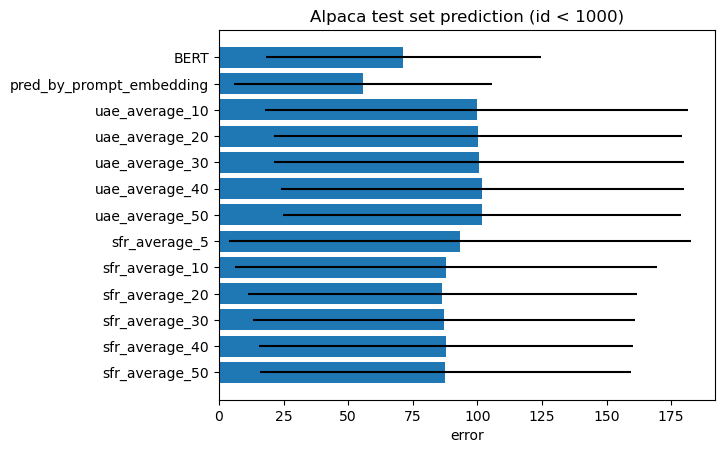

In [75]:
err_mean = np.mean(errors, axis=1)
err_std = np.std(errors, axis=1)

y_vals = list(range(len(predictors), 0, -1))

fig, ax = plt.subplots()
ax.barh(y_vals, err_mean, xerr=err_std)

yticklabels = [x for x in predictors]
yticklabels[0] = 'BERT'
plt.yticks(y_vals, yticklabels)

ax.set_xlabel('error')

plt.title('Alpaca test set prediction (id < 1000)')
plt.show()